# Deep Q-networks
Author
Rahul Kumar (Northeastern University)

In [1]:
# !pip install gym
from collections import namedtuple
import copy
import gym
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

import matplotlib.pyplot as plt
from env_v5 import register_env, tetherWorldEnv
from algorithm_v5 import q_learning, test_algorithm, load_checkpoint, on_policy_mc_control_epsilon_soft, SARSA
from tqdm import trange
from scheduler import ExponentialSchedule
from plot import plot_learning_curve, plot_return
from math import pi

/home/rahul/anaconda3/envs/gym-env/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


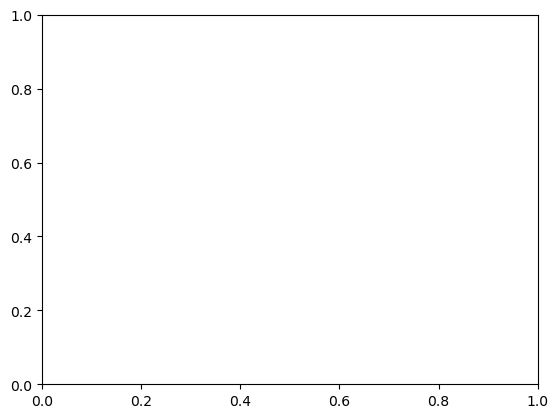

In [2]:
# Envs for training (no rendering)
register_env()
env = gym.make("tetherWorld-v0",req_winding_angle=2*pi)

In [3]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env: Gymnasium environment
    :param policy: Function which maps state to action.  If None, the random
                   policy is used.
    """

    if policy is None:
        # Random policy
        def policy(state):
            return env.action_space.sample()

    # Basic gym loop
    state, info = env.reset()
    while True:
        action = policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break
        state = next_state

## Part (a): Exponential $\varepsilon$-greedy decay

Instead of using a fixed value of $\varepsilon$, it is common to anneal $\varepsilon$ over time according to a schedule (such that initially almost all actions are exploratory). DQN used a linear decay schedule, but there we will use exponential decay, defined as:
$$\varepsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule. Beyond a specified number of time steps, $\varepsilon$ will be kept fixed at a small constant value to maintain continual exploration.

The interface to the scheduler receives the initial value, the final value, and in how many steps to go from initial to final. Your task is to compute parameters `a` and `b` to make the scheduler work as expected.

In [4]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: Initial value
        :param value_to: Final value
        :param num_steps: Number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        self.a = self.value_from
        self.b = np.log(self.value_to/self.value_from)/(num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        Returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step: The step at which to compute the interpolation
        :rtype: Float. The interpolated value
        """


        if step < 0:
            value = self.value_from
        elif step > (self.num_steps-1):
            value = self.value_to
        else:
            value = self.a * np.exp(self.b*step)
        
        return value


## Part (b): Replay memory

Now we will implement the replay memory (also called the replay buffer), the data-structure where we store previous experiences so that we can re-sample and train on them.

In [5]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer
            - state_size: Size of the state-space features for the environment
        """
        self.max_size = max_size
        self.state_size = state_size

        # Preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state: 1-D np.ndarray of state-features
        :param action: Integer action
        :param reward: Float reward
        :param next_state: 1-D np.ndarray of state-features
        :param done: Boolean value indicating the end of an episode
        """

        self.states[self.idx] = torch.tensor(state)
        self.actions[self.idx] = torch.tensor(action)
        self.rewards[self.idx] = torch.tensor(reward)
        self.next_states[self.idx] = torch.tensor(next_state)
        self.dones[self.idx] = torch.tensor(done)
        
        # Circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # Update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size: Number of transitions to sample
        :rtype: Batch
        """

        if self.size >= batch_size:
            sample_indices = np.random.choice(self.size,size=batch_size,replace=False)
        else:
            sample_indices = np.arange(self.size)

        batch = Batch(self.states[sample_indices],self.actions[sample_indices],self.rewards[sample_indices],
                                                self.next_states[sample_indices],self.dones[sample_indices])

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env: Gymnasium environment
        :param num_steps: Number of steps to populate the replay memory
        """

        state,info = env.reset()

        for _ in range(num_steps):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)

            self.add(state=state,action=action,reward=reward,next_state=next_state,done=terminated)

            if terminated or truncated:
                state,info = env.reset()
            else:
                state = next_state

            

## Part (c): Q-network

In this section, we define the object that DQN learns -- the Q-value neural network.

In [6]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim


        self.fc1 = nn.Linear(self.state_dim,self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.fc3 = nn.Linear(self.hidden_dim,self.action_dim)



    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space. This represents the Q values Q(s, .)
        """

        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        action_values = self.fc3(x)

        return action_values
    
    # Utility methods for cloning and storing models.
    
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


## Part (d): Single-batch update

In [7]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :rtype: Float. The scalar loss associated with this batch
    """
    
    # Compute actual Q-values
    values = dqn_model(batch.states).gather(1, batch.actions)

    # Compute target Q-values
    with torch.no_grad():
        max_q_values = dqn_target(batch.next_states).max(1, keepdim=True)[0]
        target_values = batch.rewards + (1 - batch.dones.int()) * gamma * max_q_values


    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # Testing that the values tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor requires gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should not require gradients'

    # Computing the scalar MSE loss between computed values and the TD-target
    # DQN originally used Huber loss, which is less sensitive to outliers
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    return loss.item()

## Part (e): DQN training loop

This is the main training loop for DQN.

In [8]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes. The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: An ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # Check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # Get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # Initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # Initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # Initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # Initialize lists to store returns, lengths, and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # Initialize structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # Use this to indicate the index of the current episode
    t_episode = 0  # Use this to indicate the time-step inside current episode

    state, info = env.reset()  # Initialize state of first episode

    # Iterate for a total of `num_steps` steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # Use t_total to indicate the time-step from the beginning of training

        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)
            
        state = torch.tensor(state, dtype=torch.float)
               
        if np.random.random() > exploration.value(t_total):
            # print("state",state)
            Q = dqn_model(state).detach()
            action = np.argmax(Q.numpy())
            
        else:
            action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)

        memory.add(state=state,action=action,reward=reward,next_state=next_state,done=terminated)

        # storing rewards
        rewards.append(reward)

        
        if (t_total+1)%4 == 0:
            batch = memory.sample(batch_size)
            training_loss = train_dqn_batch(optimizer,batch,dqn_model,dqn_target,gamma)
            losses.append(training_loss)

        
        if (t_total+1) % 10000 == 0:
            dqn_model_dict = dqn_model.state_dict()
            dqn_target.load_state_dict(dqn_model_dict)

        if terminated or truncated:

            lengths.append(len(rewards))

            # calculating return
            G = 0
            for r in reversed(rewards):
                G = r + gamma * G
            
            returns.append(G)
            
            eps = exploration.value(t_total)

            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )

            i_episode += 1
            t_episode = 0
            rewards = []
            state,info = env.reset()

        else:
            state = next_state
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )


## Part (f): Evaluation of DQN



In [9]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Training

In [10]:

gamma = 0.99

num_steps = 1_500_000
# num_steps = 100_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# Saving computed models to disk, so that we can load and visualize them later
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

/home/rahul/anaconda3/envs/gym-env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/rahul/anaconda3/envs/gym-env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/rahul/anaconda3/envs/gym-env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: int64
  logger.warn(
/home/rahul/anaconda3/envs/gym-env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within th

#### Plot the returns, lengths, and losses obtained while running DQN.

Plot both the raw data and the moving average

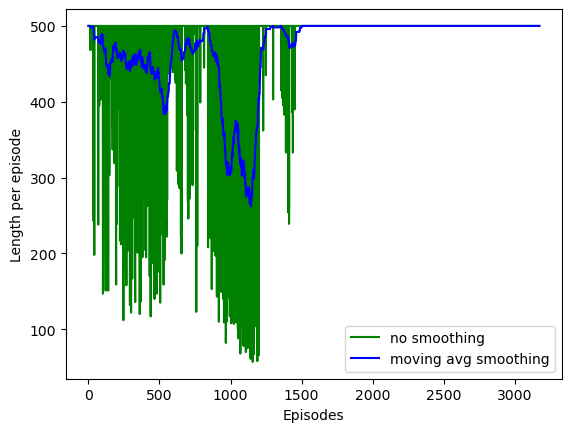

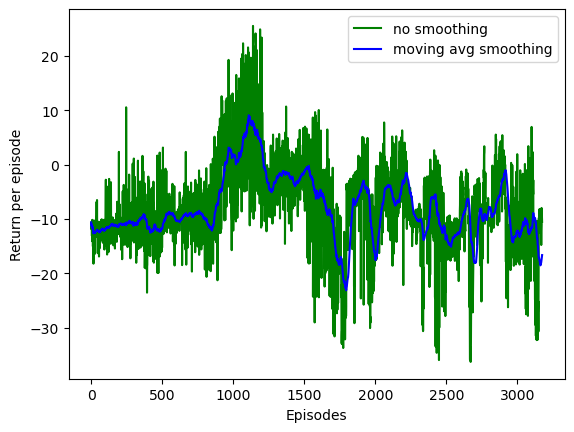

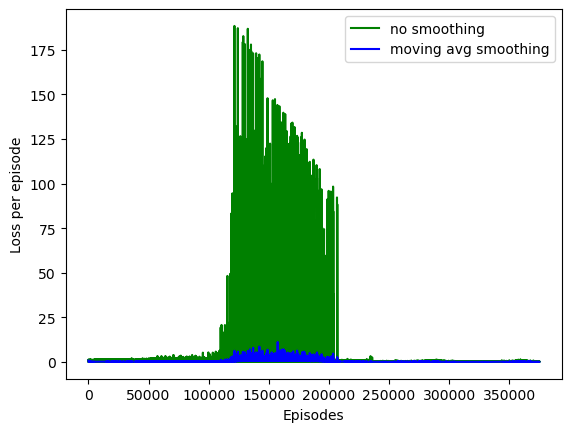

In [11]:
import matplotlib.pyplot as plt

average_lengths = moving_average(lengths)
average_returns = moving_average(returns)
average_losses = moving_average(losses)

plt.figure()
plt.plot(lengths,color='green',label='no smoothing')
plt.plot(average_lengths,color='blue',label='moving avg smoothing')
plt.xlabel("Episodes")
plt.ylabel("Length per episode")
plt.legend()

plt.figure()
plt.plot(returns,color='green',label='no smoothing')
plt.plot(average_returns,color='blue',label='moving avg smoothing')
plt.xlabel("Episodes")
plt.ylabel("Return per episode")
plt.legend()

plt.figure()
plt.plot(losses,color='green',label='no smoothing')
plt.plot(average_losses,color='blue',label='moving avg smoothing')
plt.xlabel("Episodes")
plt.ylabel("Loss per episode")
plt.legend()

plt.show()

### Visualization of the trained policies

Run the cell below and push the buttons to view the progress of the policy trained using DQN.

In [12]:
buttons_all = []

checkpoint = torch.load(f'checkpoint_tetherWorld-v0.pt')

buttons = []
for key, value in checkpoint.items():
    dqn = DQN.custom_load(value)

    def make_callback(env, dqn):
        def button_callback(button):
            for b in buttons_all:
                b.disabled = True

            render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item())

            for b in buttons_all:
                b.disabled = False

        return button_callback

    button = widgets.Button(description=f'{key.replace("_", ".")}%')
    button.on_click(make_callback(env, dqn))
    buttons.append(button)

# print(f'{key_env}:')
display(widgets.HBox(buttons))
buttons_all.extend(buttons)